# PI : matching with constraints

Leonel GOMES and Benjamin SELLES

In this project, we study many-to-one matching problems (such as the matching of students to schools) where we have non-trivial constraints on the possible match- ings. We consider in particular non-discrimination constraints, as well as budget constraints. We investigate both the deferred-acceptance algorithm and its extensions, as well as newly proposed algorithms specifically done for the constrained problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpProblem, LpVariable, lpSum, LpMinimize, LpBinary

# I - The deffered acceptance algorithm

## I.1 Capacity constraints

We first consider the simplest case, where the only constraint is a capacity constraint. Each school $s$ has a given capacity $q_s$ ∈ $N$ and can only admit up to $q_s$ students.


### Task 1 : Show that the notion of stability coincides with the standard notion from Gale and Shapley

We aim to show that the notion of stability in the given problem (with capacity constraints) coincides with the standard notion of stability in the **extended Gale-Shapley model** for many-to-one matching.

#### Extended Gale-Shapley Model with Capacity Constraints

In the **extended Gale-Shapley model**, each school $ s \in S $ has a **capacity constraint** $ q_s $, meaning it can accept at most $ q_s $ students. A matching $ \mu $ is **stable** if it satisfies the following conditions:

1. **Individual Rationality**: No student is matched to a school they prefer less than being unmatched, and no school is assigned a student it prefers less than leaving a seat empty.
2. **No Blocking Pairs**: There is no student-school pair $ (i, s) $ such that:
   - $ s \succ_i \mu_i $ (student $ i $ prefers $ s $ to their current match), and
   - Either:
     - $ |\mu_s| < q_s $ (school $ s $ has an available seat), or
     - $ i \succ_s i' $ for some $ i' \in \mu_s $ (school $ s $ prefers $ i $ to one of its currently matched students).

This is the standard notion of stability in the many-to-one Gale-Shapley model with capacity constraints.

---

#### Equivalence of Stability Notions

We now show that the stability conditions in the given problem (feasibility, individual rationality, fairness, and non-wastefulness) are equivalent to the stability conditions in the extended Gale-Shapley model.

##### 1. Feasibility
In the given problem, a matching $ \mu $ is **feasible** if $ \mu_s \in F_s $ for all $ s \in S $, where $ F_s $ is the collection of feasible sets of students for school $ s $. Under capacity constraints, $ F_s = \{ I' \subseteq I \mid |I'| \leq q_s \} $. Thus, $ \mu $ is feasible if and only if $ |\mu_s| \leq q_s $ for all $ s \in S $. This is exactly the **capacity constraint** in the extended Gale-Shapley model.

##### 2. Individual Rationality
In the given problem, $ \mu $ is **individually rational** if $ \mu_i \succ_i \emptyset $ for all $ i \in I $ such that $ \mu_i \neq \emptyset $. This means no student is matched to a school they prefer less than being unmatched. This condition is identical to the **individual rationality** condition in the extended Gale-Shapley model.

##### 3. Fairness
In the given problem, $ \mu $ is **fair** if there is no **justified envy**. That is, there are no students $ i $ and $ i' $ such that:
- $ s \succ_i \mu_i $ (student $ i $ prefers $ s $ to their current match),
- $ i' \in \mu_s $ (student $ i' $ is matched to $ s $), and
- $ i \succ_s i' $ (school $ s $ prefers $ i $ to $ i' $).

This is equivalent to the **no blocking pairs** condition in the extended Gale-Shapley model, which ensures that no student-school pair $ (i, s) $ exists where $ i $ prefers $ s $ to their current match and $ s $ either has an available seat or prefers $ i $ to one of its currently matched students.

##### 4. Non-Wastefulness
In the given problem, $ \mu $ is **non-wasteful** if there is no pair $ (i, s) \in I \times S $ such that:
- $ s \succ_i \mu_i $ (student $ i $ prefers $ s $ to their current match), and
- $ \mu_s \cup \{i\} $ is feasible at $ s $ (i.e., $ |\mu_s| < q_s $).

This is equivalent to the **no-wastefulness** condition in the extended Gale-Shapley model, which ensures that no student prefers a school with an available seat to their current match.

---

#### Conclusion

Since the conditions of **feasibility**, **individual rationality**, **fairness**, and **non-wastefulness** in the given problem are equivalent to the stability conditions in the **extended Gale-Shapley model** with capacity constraints, we conclude that the notion of stability in the given problem coincides with the standard notion of stability in the extended Gale-Shapley model.

### Task 2 : Devise and implement a variant of the deferred acceptance algorithm for the school admission problem with capacity constraints.


In [2]:
class Student:
    def __init__(self, id, preferences):
        self.id = id
        self.preferences = preferences  # Ordered list of schools
        self.current_match = None
        self.proposals = set()
        self.cost = 0
        self.quality = 0
        self.group = None

class School:
    def __init__(self, id, capacity, preferences):
        self.id = id
        self.capacity = capacity
        self.preferences = preferences  # Ordered list of students
        self.current_matches = []

# Helper functions
def prefers(preferences, student1, student2):
    """Check if student1 is preferred over student2 in preferences."""
    return preferences.index(student1) < preferences.index(student2)

# Stability under capacity constraints
def is_stable(students, schools):
    """
    Check if the matching between students and schools is stable.

    A matching is stable if there are no two agents that prefer each other over their current match.
    """
    for student in students:
        if student.current_match:
            current_school = student.current_match
            for preferred_school in student.preferences:
                if preferred_school == current_school:
                    break
                if len(preferred_school.current_matches) < preferred_school.capacity:
                    return False
                worst_student = max(preferred_school.current_matches,
                                    key=lambda s: preferred_school.preferences.index(s))
                if prefers(preferred_school.preferences, student, worst_student):
                    return False
    return True

# Task 2: Deferred acceptance algorithm
def deferred_acceptance(students, schools):
    unmatched_students = list(students)

    while unmatched_students:
        # Get the first unmatched student
        student = unmatched_students.pop(0)


        for school in student.preferences:

            # if the student has already proposed to the school, continue with the next school
            # if not, add the school to the student's proposals
            if school in student.proposals:
                continue
            student.proposals.add(school)

            # if the school has capacity, match the student and continue with the next unmatched student
            if len(school.current_matches) < school.capacity:
                school.current_matches.append(student)
                student.current_match = school
                break
            
            # if the school is full, check if the student is preferred over the worst student
            # if so, replace the worst student with the current student
            # and add the worst student to the list of unmatched students
            # then continue with the next unmatched student
            worst_student = max(school.current_matches,
                                key=lambda s: school.preferences.index(s))
            
            if prefers(school.preferences, student, worst_student):
                school.current_matches.remove(worst_student)
                school.current_matches.append(student)
                student.current_match = school
                worst_student.current_match = None
                unmatched_students.append(worst_student)
                break
            

    return {student.id: student.current_match.id if student.current_match else None
            for student in students}

The Deferred Acceptance Algorithm runs in $O(n*m*k)$ where $n$ is the number of student, $m$ is the number of school and $k$ the school capacity. In real world, we have $k<<n$, so, this algorithm runs in $O(mn)$.

## I.2 Maximum quotas

The previous algorithm does not consider student’s group. We first consider a simple case of affirmative action, based on maximum quotas. Specifically, in addition to its global quota $q_s$, each school $s$ now also has a quota per group $q_s^g$ ∈ $N$, for all $g$ ∈ $G$. That is, school $s$ can only admit up to $q_s^g$ students of group $g$. We assume that $q_s^g$ ≤ $q_s$ for all $g$, and $\sum_{g \in \mathcal{G}}$ $q_s^g$ $\geq q_s$ .

### Task 3 : Propose and implement a modification of the algorithm of Task 2 that outputs a match- ing respecting the above maximum quota constraints.

In [3]:
class GroupedSchool(School):
    def __init__(self, id, capacity, preferences, group_quotas, budget = None):
        super().__init__(id, capacity, preferences)
        self.group_quotas = group_quotas  # Dictionary: {group: max_quota}
        self.group_counts = {group: 0 for group in group_quotas}  # Tracks current group allocations
        self.budget = budget

def grouped_deferred_acceptance(students, schools):
    """
    Perform the deferred acceptance algorithm with groups quota.
    """
    unmatched_students = list(students)

    while unmatched_students:
        # Get the first unmatched student
        student = unmatched_students.pop(0)

        for school in student.preferences:
            # if the student has already proposed to the school, continue with the next school
            if school in student.proposals:
                continue
            student.proposals.add(school)

            # Check if the school has capacity and group quota
            # If so, match the student and continue with the next unmatched student
            student_group = student.group  # Assume each student has an attribute `group`
            if len(school.current_matches) < school.capacity and school.group_counts[student_group] < school.group_quotas[student_group]:
                school.current_matches.append(student)
                school.group_counts[student_group] += 1
                student.current_match = school
                break

            # If the school is full or quota is full, check if the student is preferred over the worst student regarding group quota and school capacity
            if school.group_counts[student_group] >= school.group_quotas[student_group] and school.group_quotas[student_group] > 0:
                worst_student = max(school.current_matches, key=lambda s: school.preferences.index(s) if s.group == student_group else -1)
            else:
                worst_student = max(school.current_matches, key=lambda s: school.preferences.index(s))

            # Check if the current student is preferred over the worst student
            if prefers(school.preferences, student, worst_student):
                # Remove the worst student
                school.current_matches.remove(worst_student)
                school.group_counts[worst_student.group] -= 1
                worst_student.current_match = None
                unmatched_students.append(worst_student)

                # Add the current student
                school.current_matches.append(student)
                school.group_counts[student_group] += 1
                student.current_match = school
                break

    return {student.id: student.current_match.id if student.current_match else None for student in students}


The worst case for this algorithme results in $O(n*m*k)$ complexity. We note that we could use a priority queue for school matches instead of a list to reduce "finding and replacing the worst student" to $O(ln(k))$ instead of $O(k)$. But, in real life $k$ is not too big so we decided to keep a list.

## I.3 Tests

In this section, we code the tests requested.

### Task 4 : Tests

Instance 1 below

In [4]:
# Instance 1: Fixed preferences and quotas
students_instance1 = [
    Student("i1", []),
    Student("i2", []),
    Student("i3", []),
    Student("i4", []),
]

schools_instance1 = [
    GroupedSchool("s1", 2, [], {"A": 2, "B": 2}),
    GroupedSchool("s2", 2, [], {"A": 2, "B": 2}),
]

# Assign groups to students
students_instance1[0].group = "A"
students_instance1[1].group = "A"
students_instance1[2].group = "A"
students_instance1[3].group = "B"

# Assign preferences
students_instance1[0].preferences = [schools_instance1[0], schools_instance1[1]]  # i1: s1, s2
students_instance1[1].preferences = [schools_instance1[1], schools_instance1[0]]  # i2: s2, s1
students_instance1[2].preferences = [schools_instance1[0]]  # i3: s1
students_instance1[3].preferences = [schools_instance1[1]]  # i4: s2

schools_instance1[0].preferences = [students_instance1[3], students_instance1[2], students_instance1[1], students_instance1[0]]
schools_instance1[1].preferences = [students_instance1[3], students_instance1[2], students_instance1[1], students_instance1[0]]

# Perform the matching
matches_instance1 = grouped_deferred_acceptance(students_instance1, schools_instance1)
print("Instance 1 - Matches:", matches_instance1)


Instance 1 - Matches: {'i1': 's1', 'i2': 's2', 'i3': 's1', 'i4': 's2'}


It is the expected result for instance 1

Instance 2 below:

Group A first choice matches: 32
Group B first choice matches: 4


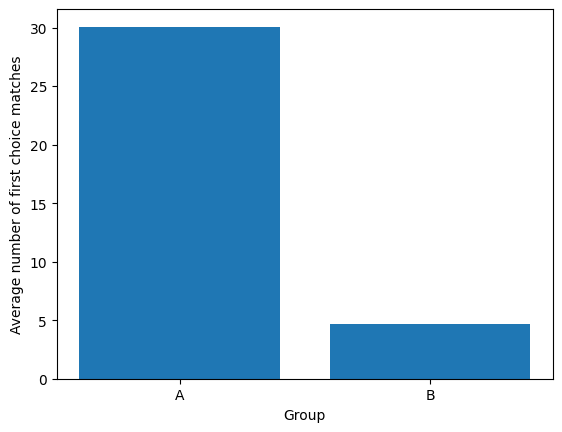

In [5]:
def generate_instance_2(n, pA=0.9):
    """
    Generate an instance of... instance 2.
    """
    students = []
    schools = [
        GroupedSchool("s1", n // 4, [], {"A": int(0.9 * n / 4), "B": int(0.9 * n / 4)}),
        GroupedSchool("s2", n // 4, [], {"A": int(0.9 * n / 4), "B": int(0.9 * n / 4)}),
    ]
    
    group_cutoff = int(pA * n)
    for i in range(n):
        student = Student(f"i{i+1}", [])
        student.group = "A" if i < group_cutoff else "B"
        students.append(student)
    
    qualities = np.random.normal(0, 1, n)
    for student, quality in zip(students, qualities):
        student.quality = quality
        if np.random.rand() < 0.5:
            student.preferences = [schools[0], schools[1]]
        else:
            student.preferences = [schools[1], schools[0]]
    
    for school in schools:
        noisy_qualities = qualities + np.random.normal(0, 1, n)
        sorted_students = [s for _, s in sorted(zip(noisy_qualities, students), reverse=True)]
        school.preferences = sorted_students
    
    return students, schools

# Generate and test the instance
students_instance2, schools_instance2 = generate_instance_2(100)
matches_instance2 = grouped_deferred_acceptance(students_instance2, schools_instance2)

# Compute statistics
num_first_choice_A = sum(1 for s in students_instance2 if s.group == "A" and s.current_match == s.preferences[0])
num_first_choice_B = sum(1 for s in students_instance2 if s.group == "B" and s.current_match == s.preferences[0])

print(f"Group A first choice matches: {num_first_choice_A}")
print(f"Group B first choice matches: {num_first_choice_B}")


# Get the average number of first choice matches for each group
def run_simulation(n, num_trials):
    results = {"A": [], "B": []}
    for _ in range(num_trials):
        students, schools = generate_instance_2(n)
        matches = grouped_deferred_acceptance(students, schools)
        for group in ["A", "B"]:
            num_first_choice = sum(1 for s in students if s.group == group and s.current_match == s.preferences[0])
            results[group].append(num_first_choice)
    return results

# Plotting the results
results = run_simulation(100, 100)

# Compute the average number of first choice matches for each group
mean_results = {group: np.mean(values) for group, values in results.items()}

# Plot the results
plt.bar(mean_results.keys(), mean_results.values())
plt.xlabel("Group")
plt.ylabel("Average number of first choice matches")
plt.show()

Results interpretation : 

As a reminder, the proportion of students in group A is 90% and the two schools have $n/4$ places and a quota of $0.9n/4$ for each group. It is therefore intuitive that belonging to a minority group is advantageous for obtaining your first choice.

Our example shows that this is indeed the case: on average, 30 students (out of 90) from group A get their first choice, i.e. 1 student out of 3; whereas for group B, 5 students (out of 10) get their first choice, i.e. 1 student out of 2. This confirms our intuition.



Instance 3 below:

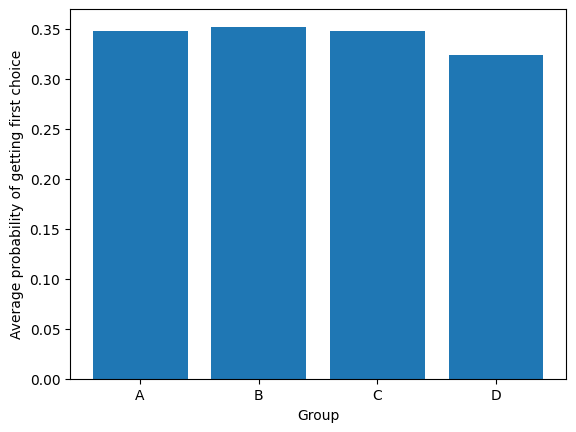

In [6]:
def generate_instance_3(n):
    """
    Self-explanatory.
    """
    groups = ["A", "B", "C", "D"]
    group_probs = [10 / 20, 6 / 20, 3 / 20, 1 / 20]
    group_quotas = {group: int(0.9 * n / 4) for group in groups}
    costs = {"A": 1, "B": 5, "C": 6, "D": 10}

    students = []
    schools = [
        GroupedSchool("s1", n // 4, [], group_quotas),
        GroupedSchool("s2", n // 4, [], group_quotas),
    ]
    
    student_groups = np.random.choice(groups, size=n, p=group_probs)
    qualities = np.random.normal(0, 1, n)
    
    for i in range(n):
        student = Student(f"i{i+1}", [])
        student.group = student_groups[i]
        student.quality = qualities[i]
        student.cost = costs[student.group]
        if np.random.rand() < 0.5:
            student.preferences = [schools[0], schools[1]]
        else:
            student.preferences = [schools[1], schools[0]]
        students.append(student)
    
    for school in schools:
        noisy_qualities = qualities + np.random.normal(0, 1, n)
        sorted_students = [s for _, s in sorted(zip(noisy_qualities, students), reverse=True)]
        school.preferences = sorted_students
    
    return students, schools

# Generate and test the instance
students_instance3, schools_instance3 = generate_instance_3(100)
matches_instance3 = grouped_deferred_acceptance(students_instance3, schools_instance3)

def run_simulation_instance3(n, num_trials):
    results = {"A": [], "B": [], "C": [], "D": []}
    for _ in range(num_trials):
        students, schools = generate_instance_3(n)
        matches = grouped_deferred_acceptance(students, schools)
        for group in ["A", "B", "C", "D"]:
            num_first_choice = sum(1 for s in students if s.group == group and s.current_match == s.preferences[0])
            results[group].append(num_first_choice)
    return results

# Plotting the results
m=500
results = run_simulation_instance3(m, 100)

groups = ["A", "B", "C", "D"]
group_probs = [10 / 20, 6 / 20, 3 / 20, 1 / 20]

# Compute the average number of first choice matches for each group
mean_results = {group: np.mean(values) for group, values in results.items()}

# Normalize the results
for i in range(len(groups)):
    mean_results[groups[i]] = mean_results[groups[i]]/(group_probs[i]*m)

# Plot the results
plt.bar(mean_results.keys(), mean_results.values())
plt.xlabel("Group")
plt.ylabel("Average probability of getting first choice")
plt.show()


Results interpretation:

As a reminder, 1 out of 2 students belongs to group A, $6/20$ to group B, $3/20$ to group C and $1/20$ to group D.

We note that the probability of getting your first choice is almost the same for each group. This goes against our intuition, but can easily be explained by the fact that the quota constraint is too low here, and therefore does not allow us to exclude students in relation to their original group.

Below, let's see what happens if we put a big quota constraint by replacing $0.9n/4$ with $0.3n/4$ : 

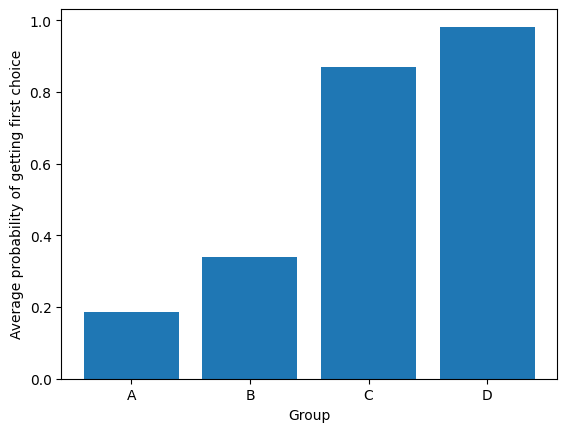

In [7]:
def generate_instance_3_quota_changed(n):
    groups = ["A", "B", "C", "D"]
    group_probs = [10 / 20, 6 / 20, 3 / 20, 1 / 20]
    group_quotas = {group: int(0.3 * n / 4) for group in groups}
    costs = {"A": 1, "B": 5, "C": 6, "D": 10}

    students = []
    schools = [
        GroupedSchool("s1", n // 4, [], group_quotas),
        GroupedSchool("s2", n // 4, [], group_quotas),
    ]
    
    student_groups = np.random.choice(groups, size=n, p=group_probs)
    qualities = np.random.normal(0, 1, n)
    
    for i in range(n):
        student = Student(f"i{i+1}", [])
        student.group = student_groups[i]
        student.quality = qualities[i]
        student.cost = costs[student.group]
        if np.random.rand() < 0.5:
            student.preferences = [schools[0], schools[1]]
        else:
            student.preferences = [schools[1], schools[0]]
        students.append(student)
    
    for school in schools:
        noisy_qualities = qualities + np.random.normal(0, 1, n)
        sorted_students = [s for _, s in sorted(zip(noisy_qualities, students), reverse=True)]
        school.preferences = sorted_students
    
    return students, schools

# Generate and test the instance
students_instance3, schools_instance3 = generate_instance_3_quota_changed(100)
matches_instance3 = grouped_deferred_acceptance(students_instance3, schools_instance3)

def run_simulation_instance3_quota_changed(n, num_trials):
    results = {"A": [], "B": [], "C": [], "D": []}
    for _ in range(num_trials):
        students, schools = generate_instance_3_quota_changed(n)
        matches = grouped_deferred_acceptance(students, schools)
        for group in ["A", "B", "C", "D"]:
            num_first_choice = sum(1 for s in students if s.group == group and s.current_match == s.preferences[0])
            results[group].append(num_first_choice)
    return results

# Plotting the results
m=500
results = run_simulation_instance3_quota_changed(m, 100)

groups = ["A", "B", "C", "D"]
group_probs = [10 / 20, 6 / 20, 3 / 20, 1 / 20]

# Compute the average number of first choice matches for each group
mean_results = {group: np.mean(values) for group, values in results.items()}

# Normalize the results
for i in range(len(groups)):
    mean_results[groups[i]] = mean_results[groups[i]]/(group_probs[i]*m)

# Plot the results
plt.bar(mean_results.keys(), mean_results.values())
plt.xlabel("Group")
plt.ylabel("Average probability of getting first choice")
plt.show()


This is the result we expected from increasing the quota constraint. 

# II - Fair rankings

The maximum quotas constraints are limited in that they do not guarantee a minimum number of students from the different groups, which non-discrimination rules typically do. A more stringent notion is known as the $4/5$-rule: for any group, the fraction of students of the group at any school cannot be less than $80$% or more than $120$% of the fraction of students of that group in $I$.

Guaranteeing that the obtained matching satisfies the $4/5$-rule is non-trivial. We consider here a first natural idea: we will modify the schools preference lists such that, for any rank k, the subset of students ranked k or better satisfy the $4/5$-rule up to one unit.

### Task 5 : Propose and implement an algorithm to change schools preference lists so that they satisfy the $4/5$-rule up to one unit while minimizing the distance to the initial ranking. 

In [8]:
def satisfy_4_5_rule(group_fractions, adjusted_preferences, group_counts_in_ranking):
    """
    Helper function to check if the 4/5 rule is satisfied.
    """
    for group, fraction in group_fractions.items():
        if not (int(1.2*fraction*len(adjusted_preferences))+1 >= group_counts_in_ranking[group] >= int(0.8 * fraction * len(adjusted_preferences))-1):
            return False
    return True

def adjust_preferences_for_4_5_rule(schools, students):
    # Calculate group fractions in the total population
    total_students = len(students)
    group_counts = {}
    for student in students:
        group_counts[student.group] = group_counts.get(student.group, 0) + 1
    group_fractions = {g: count / total_students for g, count in group_counts.items()}
    
    # Modify each school's preference list
    for school in schools:
        adjusted_preferences = []
        group_counts_in_ranking = {g: 0 for g in group_fractions.keys()}
        
        left_to_change = list(school.preferences)
        k = 0

        # Iterate through the school's preferences
        # and adjust the preferences to satisfy the 4/5 rule
        # while maintaining the order of the preferences
        # At each iteration, we try to add a student to the adjusted preferences list
        # If the 4/5 rule is violated, we remove the student and try the next student
        # If it is not violated, we remove the student from the list of students to change
        # and go back to the beginning of the list of students to change
        while left_to_change and k<100000: # Avoid infinite loops
            
            for i, student in enumerate(left_to_change):
                k+=1
                group = student.group
                adjusted_preferences.append(student)
                group_counts_in_ranking[group] += 1
                if not satisfy_4_5_rule(group_fractions, adjusted_preferences, group_counts_in_ranking):
                    # print(len(adjusted_preferences))
                    # print(student.id)
                    adjusted_preferences.pop()
                    group_counts_in_ranking[group] -= 1
                    continue
                left_to_change.pop(i)
                
                break   
        # Update the school's preferences
        school.preferences = adjusted_preferences


The time complexity for this algorithm is $O(m*n^2*g)$ (where g is the number of groups) because for each school the worst case is :
- Iterating over all students in its preference list: $O(n)$
- Checking the 4/5 rule for every addition: $O(g)$ 
- Worst-case backtracking leads to checking most students multiple times, approaching  O(n^2)$ worst-case behavior.


### Task 6 : Apply the algorithm from Task 2 on the new rankings in the instances from Task 4. Do the final matchings satisfy the $4/5$-rule?

In [9]:
def check_4_5_rule(schools, students):
    total_students = len(students)
    group_counts = {}
    for student in students:
        group_counts[student.group] = group_counts.get(student.group, 0) + 1
    group_fractions = {g: count / total_students for g, count in group_counts.items()}
    
    for school in schools:
        assigned_students = school.current_matches
        assigned_counts = {g: 0 for g in group_fractions.keys()}
        for student in assigned_students:
            assigned_counts[student.group] += 1
        
        for group, fraction in group_fractions.items():
            min_required = max(0, int((fraction * len(assigned_students)) * 0.8))
            max_allowed = np.ceil((fraction * len(assigned_students)) * 1.2)
            if not (min_required <= assigned_counts[group] <= max_allowed):
                # print(f"4/5 rule violated for school {school.id} and group {group}")
                return False
    return True

# Generate and test the instance
students, schools = generate_instance_2(50, 0.9)  # Or Instance 1/3
adjust_preferences_for_4_5_rule(schools, students)
matches = grouped_deferred_acceptance(students, schools)
print("Final Matches:", matches)
print("4/5 Rule Satisfied:", check_4_5_rule(schools, students))


Final Matches: {'i1': 's1', 'i2': None, 'i3': None, 'i4': None, 'i5': 's2', 'i6': None, 'i7': None, 'i8': 's2', 'i9': 's2', 'i10': None, 'i11': None, 'i12': 's2', 'i13': 's1', 'i14': None, 'i15': None, 'i16': None, 'i17': 's1', 'i18': None, 'i19': 's1', 'i20': 's2', 'i21': 's2', 'i22': None, 'i23': None, 'i24': None, 'i25': None, 'i26': None, 'i27': 's1', 'i28': None, 'i29': None, 'i30': 's2', 'i31': 's1', 'i32': None, 'i33': 's1', 'i34': 's1', 'i35': None, 'i36': 's2', 'i37': None, 'i38': None, 'i39': 's2', 'i40': 's1', 'i41': None, 'i42': 's1', 'i43': 's1', 'i44': None, 'i45': 's2', 'i46': None, 'i47': 's2', 'i48': 's2', 'i49': 's1', 'i50': None}
4/5 Rule Satisfied: True


# III - A fixed-point algorithm for arbitrary constraints

### Task 7 : Implement the algorithm from Yuichiro Kamada and Fuhito Kojima's book described above with a feasibility function encoding arbitrary feasible sets.

In [10]:
class FixedPointMatching:
    def __init__(self, students, schools, feasibility_function):
        self.students = students
        self.schools = schools
        self.feasibility_function = feasibility_function
        self.cutoffs = {school: 1 for school in schools}  # Step 0: Initialize cutoffs to 1

    def demand(self, school, cutoff):
        """Compute the set of students demanding a given school at the current cutoff."""
        demand_set = []
        for student in self.students:
            if school in student.preferences:
                best_school = None
                for preferred_school in student.preferences:
                    if  0 >= preferred_school.preferences.index(student) - (len(preferred_school.preferences) - self.cutoffs[preferred_school]): #ind de l'élève - ind du pire élève (cutoff)
                        if best_school is None or student.preferences.index(preferred_school) < student.preferences.index(best_school):
                            best_school = preferred_school
                if best_school == school:
                    demand_set.append(student)
        return demand_set
    
    


    def cutoff_adjustment(self):
        """Apply the cutoff adjustment function T to update the cutoffs."""
        new_cutoffs = self.cutoffs.copy()
        for school in self.schools:
            demand_set = self.demand(school, self.cutoffs[school])
            if not self.feasibility_function(school, demand_set, self.students):
                new_cutoffs[school] += 1 # Increase the cutoff
                new_cutoffs[school] = new_cutoffs[school]%(len(self.students)+1)
        return new_cutoffs

    def run_algorithm(self):
        """Run the cutoff adjustment algorithm until a fixed point is reached."""
        while True:
            new_cutoffs = self.cutoff_adjustment()
            if new_cutoffs == self.cutoffs:
                break  # Fixed point reached
            self.cutoffs = new_cutoffs
        return {school: self.demand(school, self.cutoffs[school]) for school in self.schools}


Let's compute the time complexity for this algorithm : 
- computing demand for a school:
  - the worst-case complexity of demand(school, cutoff) is $O(n*m)$ since each student checks their full preference list
- the cutoff_adjustment function:
  - Compute demand is $O(n*m)$
  - We assume the feasibility function runs in at most $O(n)$ time
  - So, the per-iteration complexity of cutoff_adjustment() is: $O(m*n*m) = O(n*m^2)$
- Running until fixed point:
  - In the worst case, cutoffs increase incrementally and loop at most $n+1$ times, so, the worst case is in $O(n)$

The total complexity is $O(m^2*n^2)$

We note that we can maybe optimize by using binary search instead of incrementing cutoffs sequentially wich lead us to $O(m^2*n*ln(n))$ complexity but it seems hard to implement.

### Task 8, 9, 10 : Tests

Test of instance 1 only with capacity constraint

In [11]:
# Instance 1: Fixed preferences and quotas
students_instance1 = [
    Student("i1", []),
    Student("i2", []),
    Student("i3", []),
    Student("i4", []),
]

schools_instance1 = [
    GroupedSchool("s1", 2, [], {"A": 2, "B": 2}),
    GroupedSchool("s2", 2, [], {"A": 2, "B": 2}),
]

# Assign groups to students
students_instance1[0].group = "A"
students_instance1[1].group = "A"
students_instance1[2].group = "A"
students_instance1[3].group = "B"

# Assign preferences
students_instance1[0].preferences = [schools_instance1[0], schools_instance1[1]]  # i1: s1, s2
students_instance1[1].preferences = [schools_instance1[1], schools_instance1[0]]  # i2: s2, s1
students_instance1[2].preferences = [schools_instance1[0]]  # i3: s1
students_instance1[3].preferences = [schools_instance1[1]]  # i4: s2

schools_instance1[0].preferences = [students_instance1[3], students_instance1[2], students_instance1[1], students_instance1[0]]
schools_instance1[1].preferences = [students_instance1[3], students_instance1[2], students_instance1[1], students_instance1[0]]

def feasibility_function1(school, demand_set, students = None): #feasibility function with only capacity constraint
        # Check capacity constraint
        if len(demand_set) > school.capacity:
            return False  # Too many students for the school's available seats
        
        return True  # The assignment is feasible

# Perform the matching
fixed_point_matching = FixedPointMatching(students_instance1, schools_instance1, feasibility_function1)
dic = fixed_point_matching.run_algorithm()

for school, students in dic.items():
    print(f"School {school.id}: {', '.join([student.id for student in students])}")



School s1: i1, i3
School s2: i2, i4


Test of instance 2 with only capacity constraint

In [12]:
# Generate and test the instance
students_instance2, schools_instance2 = generate_instance_2(100)

fixed_point_matching = FixedPointMatching(students_instance2, schools_instance2, feasibility_function1)
dic = fixed_point_matching.run_algorithm()

for school, students in dic.items():
    print(f"School {school.id}: {', '.join([student.id for student in students])}")


def get_first_choice_matches(dic):
    first_choice_matches = {group: 0 for group in ["A", "B"]}
    for school, students in dic.items():
        for student in students:
            if student.preferences[0] == school:
                first_choice_matches[student.group] += 1
    return first_choice_matches

first_choice_matches = get_first_choice_matches(dic)

# Print the number of first choice matches for each group
for group, count in first_choice_matches.items():
    print(f"Group {group}: {count} first choice matches")
    


School s1: i3, i6, i12, i19, i25, i30, i31, i37, i41, i47, i48, i49, i51, i56, i59, i61, i64, i76, i78, i84, i85, i90, i93, i94, i99
School s2: i4, i7, i9, i10, i11, i18, i22, i24, i28, i29, i34, i38, i45, i55, i60, i62, i68, i75, i79, i81, i86, i88, i89, i91, i95
Group A: 32 first choice matches
Group B: 5 first choice matches


The algorithm seems to work well.

Test of instance 2 with capacity and group quotas constraints

In [69]:
def feasibility_function2(school, demand_set, student=None):
        # Check capacity constraint
        if len(demand_set) > school.capacity:
            return False  # Too many students for the school's available seats
        
        # Check maximum quota constraints
        group_counts = {}
        for student in demand_set:
            group_counts[student.group] = group_counts.get(student.group, 0) + 1
        
        for group, count in group_counts.items():
            if count > school.group_quotas.get(group, float('inf')):  # If no quota defined, assume infinite
                return False  # A group exceeded its allowed maximum quota
        
        return True  # The assignment is feasible
    

# Generate and test the instance
students_instance2, schools_instance2 = generate_instance_2(100)
fixed_point_matching = FixedPointMatching(students_instance2, schools_instance2, feasibility_function2)
dic = fixed_point_matching.run_algorithm()

for school, students in dic.items():
    print(f"School {school.id}: {', '.join([student.id for student in students])}")
    
#i want th number of student with first choice in each group
def get_first_choice_matches(dic):
    first_choice_matches = {group: 0 for group in ["A", "B"]}
    for school, students in dic.items():
        for student in students:
            if student.preferences[0] == school:
                first_choice_matches[student.group] += 1
    return first_choice_matches

first_choice_matches = get_first_choice_matches(dic)

# Print the number of first choice matches for each group
for group, count in first_choice_matches.items():
    print(f"Group {group}: {count} first choice matches")

School s1: i10, i14, i20, i24, i26, i30, i34, i37, i40, i42, i44, i48, i50, i53, i55, i59, i67, i73, i81, i86, i88, i91, i94, i96, i98
School s2: i2, i7, i13, i15, i16, i19, i25, i27, i41, i51, i54, i56, i63, i64, i68, i71, i72, i74, i77, i84, i87, i89, i92, i97, i100
Group A: 28 first choice matches
Group B: 6 first choice matches


Again, the probability of getting your first choice is better if you are in group B (6/10, it's around 1/3 for students in group A), that's logical because of quotas constraints

Test of instance 2 with capacity, group quotas and $4/5$-rule constraints

In [14]:
def feasibility_function3(school, demand_set, students):
        # Check capacity constraint
        if len(demand_set) > school.capacity:
            return False  # Too many students for the school's available seats
        
        # Check maximum quota constraints
        group_counts = {}
        for student in demand_set:
            group_counts[student.group] = group_counts.get(student.group, 0) + 1
        
        for group, count in group_counts.items():
            if count > school.group_quotas.get(group, float('inf')):  # If no quota defined, assume infinite
                return False  # A group exceeded its allowed maximum quota
        #add 4/5 rule
        
        total_students = len(students)
        group_counts = {}
        for student in students:
            group_counts[student.group] = group_counts.get(student.group, 0) + 1
        group_fractions = {g: count / total_students for g, count in group_counts.items()}
    
        demand_group_counts = {}
        for student in demand_set:
            demand_group_counts[student.group] = demand_group_counts.get(student.group, 0) + 1
        
        for group, fraction in group_fractions.items():
            min_required = max(0, int((fraction * len(demand_set)) * 0.8))
            max_allowed = int((fraction * len(demand_set)) * 1.2)
            if not (min_required <= demand_group_counts.get(group,0) <= max_allowed):
                return False
            
        return True  # The assignment is feasible
    
# Generate and test the instance
students_instance2, schools_instance2 = generate_instance_2(100)

fixed_point_matching = FixedPointMatching(students_instance2, schools_instance2, feasibility_function3)
dic = fixed_point_matching.run_algorithm()

# count quotas in each group
group_counts = {group: 0 for group in ["A", "B"]}
for school, students in dic.items():
    for student in students:
        group_counts[student.group] += 1


#check the 4/5 rule on dic
for school, demand_set in dic.items():
    if not feasibility_function3(school, demand_set, students_instance2):
        print(f"4/5 rule violated for school {school.id}")

for school, students in dic.items():
    print(f"School {school.id}: {', '.join([student.id for student in students])}")
    
#i want th number of student with first choice in each group
def get_first_choice_matches(dic):
    first_choice_matches = {group: 0 for group in ["A", "B"]}
    for school, students in dic.items():
        for student in students:
            if student.preferences[0] == school:
                first_choice_matches[student.group] += 1
    return first_choice_matches


first_choice_matches = get_first_choice_matches(dic)

# Print the number of first choice matches for each group
for group, count in first_choice_matches.items():
    print(f"Group {group}: {count} first choice matches")

School s1: i30
School s2: i9, i11, i13, i22, i25, i27, i48, i49, i50, i52, i61, i71, i86, i92
Group A: 7 first choice matches
Group B: 0 first choice matches


Sometimes, the algorithm does not stop, we see that the 4/5 rule add a problem in some cases.

Test of instance 3 with capacity, group quotas and $4/5$-rule constraints

In [71]:
# Generate and test the instance
students_instance3, schools_instance3 = generate_instance_3(100)

fixed_point_matching = FixedPointMatching(students_instance3, schools_instance3, feasibility_function3)
dic = fixed_point_matching.run_algorithm()

# count quotas in each group
group_counts = {group: 0 for group in ["A", "B","C","D"]}
for school, students in dic.items():
    for student in students:
        group_counts[student.group] += 1


#check the 4/5 rule on dic
for school, demand_set in dic.items():
    if not feasibility_function3(school, demand_set, students_instance2):
        print(f"4/5 rule violated for school {school.id}")

for school, students in dic.items():
    print(f"School {school.id}: {', '.join([student.id for student in students])}")
    
#i want th number of student with first choice in each group
def get_first_choice_matches(dic):
    first_choice_matches = {group: 0 for group in ["A", "B", "C", "D"]}
    for school, students in dic.items():
        for student in students:
            if student.preferences[0] == school:
                first_choice_matches[student.group] += 1
    return first_choice_matches


first_choice_matches = get_first_choice_matches(dic)

# Print the number of first choice matches for each group
for group, count in first_choice_matches.items():
    print(f"Group {group}: {count} first choice matches")

4/5 rule violated for school s1
School s1: i1, i5, i6, i20, i24, i25, i60, i72, i78, i85, i95, i99
School s2: 
Group A: 3 first choice matches
Group B: 3 first choice matches
Group C: 0 first choice matches
Group D: 0 first choice matches


The 4/5 rule is violated or the program does not run, so we can conclude that by adding the 4/5 rule, the algorithme does not work anymore.

# IV - Matching without stability constraints

In this last section, we disregard stability conditions for the matchings and instead look for “optimal” matchings in a centralized sense (i.e., assuming that a central authority can enforce the matching even in the presence of blocking pairs). Instead of a capacity constraint, we now assume that each school $s$ has a budget constraint $W_s$, that is, the school can admit a subset $I′$ of students only if $\sum_{i \in I'}$ $w_i$ $\leq W_s$.

## IV.1 The case of a single school

### Task 11 : Propose and implement an algorithm that maximizes the number of assigned students with a budget constraints and the 4/5-rule constraint.

In [72]:
def optimal_matching_with_budget(school, students, budget):
    """
    Finds the maximum number of students that can be assigned to the given school
    while respecting the budget constraint and the 4/5 rule.
    
    """
    # Sort students by weight (ascending) to maximize the number of assigned students
    sorted_students = sorted(students, key=lambda s: s.cost)
    
    assigned_students = []
    total_weight = 0
    
    left_to_change = list(sorted_students)
    k = 0
    while left_to_change and k<100000 and total_weight <= budget:
        for i, student in enumerate(left_to_change):
            k+=1
            if total_weight + student.cost <= budget:
                # Tentatively assign the student
                assigned_students.append(student)
                total_weight += student.cost
                
                # Check 4/5 rule
                school.current_matches = assigned_students
                if not check_4_5_rule([school], students):
                    # If rule is violated, remove last student
                    assigned_students.pop()
                    total_weight -= student.cost
                    continue
            left_to_change.pop(i)
    
    return assigned_students 

Let's compute the time complexity for this algorithm : 
- Sorting students: $O(n*ln(n))
- Iterating through students: $O(n)$
- Checking the 4/5 rule per assignment: $O(n)$
Since the 4/5 rule check happens in the worst case for every student, the total worst-case complexity is: 

$O(n*ln(n)+n^2) = O(n^2)$

### Task 12 : Tests

In [73]:
# Define students
students_instance1 = [
    Student("i1", ["merged_s1"]),  # i1 prefers merged_s1
    Student("i2", ["merged_s1"]),  # i2 prefers merged_s1
    Student("i3", ["merged_s1"]),  # i3 prefers merged_s1
    Student("i4", ["merged_s1"]),  # i4 prefers merged_s1
]

# Assign groups
students_instance1[0].group = "A"  # i1 in group A
students_instance1[1].group = "A"  # i2 in group A
students_instance1[2].group = "A"  # i3 in group A
students_instance1[3].group = "B"  # i4 in group B

# Assign costs (wi values)
students_instance1[0].cost = 1  # w1
students_instance1[1].cost = 1  # w2
students_instance1[2].cost = 1  # w3
students_instance1[3].cost = 10  # w4

# Define the single merged school
merged_school = GroupedSchool(
    id="merged_s1",
    capacity=4,  # Single school with 2 available slots
    preferences=[students_instance1[3], students_instance1[2], students_instance1[1], students_instance1[0]],  # Order from s1/s2
    group_quotas={"A":4, "B":4},  # No group quotas in this version
    budget=11  # Budget constraint
)

# Store in a list for easier use in algorithms
schools_instance1 = [merged_school]


In [74]:
final = optimal_matching_with_budget(merged_school, students_instance1, merged_school.budget)
for s in final:
    print(s.id)

i1
i3
i2


In [75]:
def generate_instance_2_merged(n, pA=0.7):
    students = []
    
    # Définition de la nouvelle école fusionnée
    merged_school = GroupedSchool(
        id="merged_s1",
        capacity=n // 2,  # Ajustable selon le besoin, ici n/2 pour une répartition large
        preferences=[],  # Sera mis à jour après
        group_quotas={"A":n, "B":n},  # Plus de quotas, seulement un budget
        budget=3 * n  # Nouveau budget défini par l'énoncé
    )

    # Génération des étudiants avec groupes
    group_cutoff = int(pA * n)
    for i in range(n):
        student = Student(f"i{i+1}", ["merged_s1"])  # Tous postulent à merged_s1
        student.group = "A" if i < group_cutoff else "B"
        student.cost = 1 if student.group == "A" else 10  # Coût selon le groupe
        students.append(student)

    # Assignation des qualités
    qualities = np.random.normal(0, 1, n)
    for student, quality in zip(students, qualities):
        student.quality = quality
    
    # Génération des préférences de l'école fusionnée avec du bruit sur les qualités
    noisy_qualities = qualities + np.random.normal(0, 1, n)
    sorted_students = [s for _, s in sorted(zip(noisy_qualities, students), reverse=True)]
    merged_school.preferences = sorted_students
    
    return students, [merged_school]

In [76]:
instance2 = generate_instance_2_merged(100)
students_instance2 = instance2[0]
schools_instance2 = instance2[1]

# Perform the matching
match_final_instance_2 = optimal_matching_with_budget(schools_instance2[0], students_instance2, schools_instance2[0].budget)

groupA=0
total_eleve = 0
for s in match_final_instance_2:
    if s.group == "A":
        groupA+=1
    total_eleve+=1
print("Group A:", groupA)
print("Total students:", total_eleve)

Group A: 60
Total students: 84


## IV.2 The case of a multiple schools

### Task 13 : Propose and implement an algorithm that minimizes the total students penalty with a budget constraints and the 4/5-rule constraint.

We can express this problem into a (integer) linear programming problem. 

Let's use the variables $x_{i,s}$ for $i\in I$ and $s\in S\cup \{ \empty \}$ with the idea that $x_{i,s}\in\{0,1\}$ and $x_{i,s} = 1$ if and only if student $i$ is assigned to school $s$.

We denote $w_{i,s}, l_{i,s}$ the cost and penalty of assigning student $i$ to school $s$.

Thus we are trying to minimize the function $\sum_{i\in I, s\in S} l_{i,s}x_{i,s}$ under the constraints : 
$$ \forall s\in S, \sum_{i}x_{i,s}w_{i,s} \le W_s$$
$$ \forall i\in I, \sum_{s} x_{i,s}\le 1$$
$$ \forall i \in I, \forall s \in S, x_{i,s} \ge 0$$
Then if we denote the set of all groups by $G$ and $r_g$ the ratio of group $g$ within $I$, we have  

$$ \forall s \in S, \forall g \in G, \sum_{i\in g}x_{i,s} \ge 0.8 r_g \sum_{i}x_{i,s}$$ 
and 
$$  \forall s \in S, \forall g \in G, \sum_{i\in g}x_{i,s} \le 1.2 r_g \sum_{i}x_{i,s} $$

With this, 

- The first constraint ensures that each school doesnt exceed its budget.
- The second and third constraints ensure that each student can be assigned to at most one school (here we suppose that $\empty \in S$) and that the variables will have the desired range of values.
- The last two constraints will ensure that the 4/5-rule is respected. Maybe a $\pm 1$ should be added to get less restrictive inequalities in some edge cases

We can then add the integer constraint and solve with classic ILP algorithms.

In [77]:
def optimize_student_assignment(students, schools, groups):
    problem = LpProblem("Student_Assignment_MinPenalty", LpMinimize)
    
    # Decision variables: x[i][s] = 1 if student i is assigned to school s
    x = { (i.id, s.id): LpVariable(f"x_{i.id}_{s.id}", cat=LpBinary) for i in students for s in schools }
    
    # Additional variable for unassigned students
    y = { i.id: LpVariable(f"y_{i.id}", cat=LpBinary) for i in students }
    
    # Objective function: Minimize total penalty
    num_schools = len(schools)
    problem += lpSum(
        x[i.id, s.id] * ( (i.preferences.index(s) + 1) ** 2 )
        for i in students for s in i.preferences
    ) + lpSum(y[i.id] * ((num_schools + 1) ** 2) for i in students)
    
    # Constraint 3: 4/5 Rule Constraint
    total_students = len(students)
    group_counts = {}
    for student in students:
        group_counts[student.group] = group_counts.get(student.group, 0) + 1
    group_fractions = {g: count / total_students for g, count in group_counts.items()}
    for s in schools:
        assigned_students = [i for i in students if (i.id, s.id) in x]
        group_counts = {g: lpSum(x[i.id, s.id] for i in assigned_students if i.group == g) for g in group_counts.keys()}
        
        for g in group_counts.keys():
            min_required = 0.8 * group_fractions[g] * lpSum(x[i.id, s.id] for i in students)  # 80% lower bound
            max_allowed = 1.2 * group_fractions[g] * lpSum(x[i.id, s.id] for i in students) # 120% upper bound
            problem += group_counts[g] >= min_required
            problem += group_counts[g] <= max_allowed


    # Constraint 1: Each student is assigned to at most one school or remains unmatched
    for i in students:
        problem += lpSum(x[i.id, s.id] for s in schools) + y[i.id] == 1
    
    # Constraint 2: Budget constraint for each school
    for s in schools:
        problem += lpSum(x[i.id, s.id] * i.cost for i in students if (i.id, s.id) in x) <= s.budget
    
    
    # Solve the problem
    problem.solve()
    
    # Extract results
    assignments = {s.id: [] for s in schools}
    for i in students:
        assigned = False
        for s in schools:
            if x[i.id, s.id].varValue == 1:
                assignments[s.id].append(i.id)
                assigned = True
        if not assigned:
            print(f"Student {i.id} is not assigned and gets penalty {((num_schools + 1) ** 2)}")
    
    return assignments


### Task 14 : Tests

Let's test for the instance 2 and change the number of student in group A.

In [78]:
def generate_instance_2_with_budget(n, pA=0.9,):
    students = []
    # Augmenter le budget par un facteur de 10 pour permettre plus d'élèves du groupe B
    budget = 3*n  # Modification ici
    schools = [
        GroupedSchool("s1", n//4, [], {"A": int(0.9 * n /4), "B": int(0.9 * n /4)}, budget),
        GroupedSchool("s2", n//4, [], {"A": int(0.9 * n /4), "B": int(0.9 * n /4)}, budget),
    ]
    
    group_cutoff = int(pA * n)
    for i in range(n):
        student = Student(f"i{i+1}", [])
        student.group = "A" if i < group_cutoff else "B"
        student.cost = 1 if student.group == "A" else 10  # Conserver la différence de coût
        students.append(student)
    
    qualities = np.random.normal(0, 1, n)
    for student, quality in zip(students, qualities):
        student.quality = quality
        if np.random.rand() < 0.5:
            student.preferences = [schools[0], schools[1]]
        else:
            student.preferences = [schools[1], schools[0]]
    
    for school in schools:
        noisy_qualities = qualities + np.random.normal(0, 1, n)
        sorted_students = [s for _, s in sorted(zip(noisy_qualities, students), reverse=True)]
        school.preferences = sorted_students
    
    return students, schools

Below, there is 2 tests with a different proportion of students in group A, for the first one we put 40% of students in group A, and for the second one we put 90% of students in group A.

In [79]:
test = generate_instance_2_with_budget(100, 0.4)
students_test = test[0]
schools_test = test[1]

result = optimize_student_assignment(students_test, schools_test, ["A", "B"])
for school, students in result.items():
    print(f"School {school}: {', '.join(students)}")
    
for school, students in result.items():
    print(f"School {school}: {len(students)} students")


def get_group_counts(result, students):
    group_counts = {school: {"A": 0, "B": 0} for school in result.keys()}
    for school, studentss in result.items():
        for student in students:
            if student.id in studentss:
                group_counts[school][student.group] += 1
    return group_counts

group_counts = get_group_counts(result, students_test)
for school, counts in group_counts.items():
    print(f"School {school}: {counts['A']} students in group A, {counts['B']} students in group B")
    


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/benjaminselles/Desktop/matching/matching/lib/python3.13/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/1p/1m8pwlhx1fl13sl23s4fqslw0000gn/T/fc3b8343188a49a8b8a2a53e0b4e807e-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/1p/1m8pwlhx1fl13sl23s4fqslw0000gn/T/fc3b8343188a49a8b8a2a53e0b4e807e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 115 COLUMNS
At line 2316 RHS
At line 2427 BOUNDS
At line 2728 ENDATA
Problem MODEL has 110 rows, 300 columns and 1300 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 132 - 0.00 seconds
Cgl0004I processed model has 110 rows, 300 columns (300 integer (300 of which binary)) and 1300 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 4 integers unsatisfied sum - 1.2
Cbc0038I Pass   1: s

The result above is very interesting : We had 40 students in group A and all of them are assigned (because they are cheaper than students in group B and the algorithm could keep the 4/5 rule and assign everyone). Each school spent an amount of 300 wich is the total budget

In [80]:
test = generate_instance_2_with_budget(100, 0.9)
students_test = test[0]
schools_test = test[1]

result = optimize_student_assignment(students_test, schools_test, ["A", "B"])
for school, students in result.items():
    print(f"School {school}: {', '.join(students)}")
    
# i want to print the number of students assigned to each school
for school, students in result.items():
    print(f"School {school}: {len(students)} students")
    
    
# i want to print the number of students assigned to each group
group_counts = {group: 0 for group in ["A", "B"]}
for school, students in result.items():
    for student in students:
        group_counts[students_test[int(student[1:])-1].group] += 1
        
for group, count in group_counts.items():
    print(f"Group {group}: {count} students")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/benjaminselles/Desktop/matching/matching/lib/python3.13/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/1p/1m8pwlhx1fl13sl23s4fqslw0000gn/T/ff11ec25f029426891d00293c8fe38cd-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/1p/1m8pwlhx1fl13sl23s4fqslw0000gn/T/ff11ec25f029426891d00293c8fe38cd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 115 COLUMNS
At line 2316 RHS
At line 2427 BOUNDS
At line 2728 ENDATA
Problem MODEL has 110 rows, 300 columns and 1300 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 100 - 0.00 seconds
Cgl0004I processed model has 106 rows, 300 columns (300 integer (300 of which binary)) and 900 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found

In this exemple, the budget (wich is $3*n$ for each school) is too big, so, the algorithm can assign all students. 

Now, let's do the same for instance 3. As a reminder, in Instance 3 we have : 
- 1/2 students in group A with a cost of 1
- 3/10 students in group B with a cost of 5
- 3/20 students in group C with a cost of 6
- 1/20 students in group D with a cost of 10    

In [81]:

def generate_instance_3_with_budget(n, budget=100):
    groups = ["A", "B", "C", "D"]
    group_probs = [10 / 20, 6 / 20, 3 / 20, 1 / 20]
    group_quotas = {group: int(0.9 * n / 4) for group in groups}
    costs = {"A": 1, "B": 5, "C": 6, "D": 10}

    students = []
    schools = [
        GroupedSchool("s1", n // 4, [], group_quotas, budget),
        GroupedSchool("s2", n // 4, [], group_quotas, budget),
    ]
    
    student_groups = np.random.choice(groups, size=n, p=group_probs)
    qualities = np.random.normal(0, 1, n)
    
    for i in range(n):
        student = Student(f"i{i+1}", [])
        student.group = student_groups[i]
        student.quality = qualities[i]
        student.cost = costs[student.group]
        if np.random.rand() < 0.5:
            student.preferences = [schools[0], schools[1]]
        else:
            student.preferences = [schools[1], schools[0]]
        students.append(student)
    
    for school in schools:
        noisy_qualities = qualities + np.random.normal(0, 1, n)
        sorted_students = [s for _, s in sorted(zip(noisy_qualities, students), reverse=True)]
        school.preferences = sorted_students
    
    return students, schools

In [83]:
test_1 = generate_instance_3_with_budget(100, 100)
students_test_1 = test_1[0]
schools_test_2 = test_1[1]

result = optimize_student_assignment(students_test_1, schools_test_2, ["A", "B", "C", "D"])
for school, students in result.items():
    print(f"School {school}: {', '.join(students)}")
    
for school, students in result.items():
    print(f"School {school}: {len(students)} students")


def get_group_counts(result, students):
    group_counts = {school: {"A": 0, "B": 0, "C":0, "D":0} for school in result.keys()}
    for school, students_id in result.items():
        for student in students:
            if student.id in students_id:
                group_counts[school][student.group] += 1
    return group_counts

group_counts = get_group_counts(result, students_test_1)

for school, counts in group_counts.items():
    print(f"School {school}: {counts['A']} students in group A, {counts['B']} students in group B, {counts['C']} students in group C, {counts['D']} students in group D")
    


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/benjaminselles/Desktop/matching/matching/lib/python3.13/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/1p/1m8pwlhx1fl13sl23s4fqslw0000gn/T/788ba4ef2b3d43bcb7ed87f352f5df97-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/1p/1m8pwlhx1fl13sl23s4fqslw0000gn/T/788ba4ef2b3d43bcb7ed87f352f5df97-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 123 COLUMNS
At line 3124 RHS
At line 3243 BOUNDS
At line 3544 ENDATA
Problem MODEL has 118 rows, 300 columns and 2100 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 387.256 - 0.00 seconds
Cgl0004I processed model has 118 rows, 300 columns (300 integer (300 of which binary)) and 2100 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 16 integers unsatisfied sum - 3.12821
Cbc0038I Pa

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/benjaminselles/Desktop/matching/matching/lib/python3.13/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/1p/1m8pwlhx1fl13sl23s4fqslw0000gn/T/68806b2a264346edb73fd688b3e26aaa-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/1p/1m8pwlhx1fl13sl23s4fqslw0000gn/T/68806b2a264346edb73fd688b3e26aaa-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 123 COLUMNS
At line 3124 RHS
At line 3243 BOUNDS
At line 3544 ENDATA
Problem MODEL has 118 rows, 300 columns and 2100 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 428.302 - 0.00 seconds
Cgl0004I processed model has 118 rows, 300 columns (300 integer (300 of which binary)) and 2100 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 16 integers unsatisfied sum - 2.83019
Cbc0038I Pa

The algorithm works well !

Thank you for reading !